<a href="https://colab.research.google.com/github/KatBCN/MUD-Lab-LangDet/blob/main/Assignment1_MUD_Part2_stopwords_multilingual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mining Unstructured Data - Lab 1

## Introduction

Studying the impact of different processing techniques on NLP task.

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
#!pip install utils
#from utils import *

In [14]:
import argparse
import numpy as np
import nltk
import matplotlib.pyplot as plt
import pandas as pd
import random
import scipy
import seaborn as sn
import colorcet as cc
import re


from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


Stop Words References: 
- https://practicaldatascience.co.uk/machine-learning/how-to-preprocess-text-for-nlp-in-four-easy-steps
- https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk
- https://www.nltk.org/nltk_data/
- https://www.nltk.org/howto/corpus.html?highlight=stopwords

In [15]:
#preprocess

nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize


#Tokenizer function. You can add here different preprocesses.
def preprocess(sentence, labels):
    '''
    This preprocess stems words using Porter Stemmer from nltk.

    Input: Sentence in string format
    Output: Preprocessed sentence as a string
    '''
    
    #tokenize sentence into a list of words
    X_token = sentence.apply(nltk.word_tokenize)
    #create set of stopwords for every language
    stops = set()
    for language in (nltk.corpus.stopwords.fileids()):
      stops.update(nltk.corpus.stopwords.words(language))
    #remove stop words from each row
    X_noStops = X_token.apply(lambda row:[word for word in row if not word in stops])
    #rejoin words in list as sentence
    sentence = X_noStops.apply(lambda row: (" ".join(row)))

    return sentence,labels

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
# classifiers

# You may add more classifier methods replicating this function
def applyNaiveBayes(X_train, y_train, X_test):
    '''
    Task: Given some features train a Naive Bayes classifier
          and return its predictions over a test set
    Input; X_train -> Train features
           y_train -> Train_labels
           X_test -> Test features 
    Output: y_predict -> Predictions over the test set
    '''
    trainArray = toNumpyArray(X_train)
    testArray = toNumpyArray(X_test)
    
    clf = MultinomialNB()
    clf.fit(trainArray, y_train)
    y_predict = clf.predict(testArray)
    return y_predict

In [17]:
# utils

def compute_features(X_train, 
                     X_test, 
                     analyzer='char', 
                     max_features=None):
  '''
  Task: Compute a matrix of token counts given a corpus. 
        This matrix represents the frecuency any pair of tokens appears
        together in a sentence.
 
  Input: X_train -> Train sentences
         X_test -> Test sentences
         analyzer -> Granularity used to process the sentence 
                    Values: {word, char}
         tokenizer -> Callable function to apply to the sentences before compute.
  
  Output: unigramFeatures: Cout matrix
          X_unigram_train_raw: Features computed for the Train sentences
          X_unigram_test_raw: Features computed for the Test sentences 
  '''
  
  unigramVectorizer = CountVectorizer(analyzer=analyzer,
                                      max_features=max_features,
                                      ngram_range=(1,1))
  
  X_unigram_train_raw = unigramVectorizer.fit_transform(X_train)
  X_unigram_test_raw = unigramVectorizer.transform(X_test)
  unigramFeatures = unigramVectorizer.get_feature_names()
  return unigramFeatures, X_unigram_train_raw, X_unigram_test_raw
    


def compute_coverage(features, split, analyzer='char'):
  '''
  Task: Compute the proportion of a corpus that is represented by
        the vocabulary. All non covered tokens will be considered as unknown
        by the classifier.
  
  Input: features -> Count matrix
         split -> Set of sentence 
         analyzer -> Granularity level {'word', 'char'}
  
  Output: proportion of covered tokens
  '''
  total = 0.0
  found = 0.0
  for sent in split:
    #The following may be affected by your preprocess function. Modify accordingly
    sent = sent.split(' ') if analyzer == 'word' else list(sent)
    total += len(sent)
    for token in sent:
      if token in features:
        found += 1.0
  return found / total

# Utils for conversion of different sources into numpy array
def toNumpyArray(data):
    '''
    Task: Cast different types into numpy.ndarray
    Input: data ->  ArrayLike object
    Output: numpy.ndarray object
    '''
    data_type = type(data)
    if data_type == np.ndarray:
        return data
    elif data_type == list:
        return np.array(data_type)
    elif data_type == scipy.sparse.csr.csr_matrix:
        return data.toarray()
    print(data_type)
    return None    
  
def normalizeData(train, test):
    '''
    Task: Normalize data to train classifiers. This process prevents errors
          due to features with different scale
    
    Input: train -> Train features
           test -> Test features

    Output: train_result -> Normalized train features
            test_result -> Normalized test features
    '''
    train_result = normalize(train, norm='l2', axis=1, copy=True, return_norm=False)
    test_result = normalize(test, norm='l2', axis=1, copy=True, return_norm=False)
    return train_result, test_result


def plot_F_Scores(y_test, y_predict):
    '''
    Task: Compute the F1 score of a set of predictions given
          its reference

    Input: y_test: Reference labels 
           y_predict: Predicted labels

    Output: Print F1 score
    '''
    f1_micro = f1_score(y_test, y_predict, average='micro')
    f1_macro = f1_score(y_test, y_predict, average='macro')
    f1_weighted = f1_score(y_test, y_predict, average='weighted')
    print("F1: {} (micro), {} (macro), {} (weighted)".format(f1_micro, f1_macro, f1_weighted))

def plot_Confusion_Matrix(y_test, y_predict):
    cmap = sn.cubehelix_palette(20, start=.1, rot=-.75)
    '''
    Task: Given a set of reference and predicted labels plot its confussion matrix
    
    Input: y_test ->  Reference labels
           y_predict -> Predicted labels
           color -> [Optional] Color used for the plot
    
    Ouput: Confussion Matrix plot
    '''
    allLabels = list(set(list(y_test) + list(y_predict)))
    allLabels.sort()
    confusionMatrix = confusion_matrix(y_test, y_predict, labels=allLabels)
    unqiueLabel = np.unique(allLabels)
    df_cm = pd.DataFrame(confusionMatrix, columns=unqiueLabel, index=unqiueLabel)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sn.set(font_scale=0.8) # for label size
    sn.set(rc={'figure.figsize':(15, 15)})
    sn.heatmap(df_cm, cmap=cmap, annot=True, annot_kws={"size": 12}, fmt='g', linewidth=0.3, cbar_kws={"shrink": .8})# font size
    plt.show()


def plotPCA(x_train, x_test,y_test, langs):
    '''
    Task: Given train features train a PCA dimensionality reduction
          (2 dimensions) and plot the test set according to its labels.
    
    Input: x_train -> Train features
           x_test -> Test features
           y_test -> Test labels
           langs -> Set of language labels

    Output: Print the amount of variance explained by the 2 first principal components.
            Plot PCA results by language
            
    '''
    pca = PCA(n_components=2)
    pca.fit(toNumpyArray(x_train))
    pca_test = pca.transform(toNumpyArray(x_test))
    print('Variance explained by PCA:', pca.explained_variance_ratio_)
    y_test_list = np.asarray(y_test.tolist())
    pale=sn.color_palette(cc.glasbey, n_colors=25)
    markis = ['d','^','^','s','.','s','.','.','.','s','^','.','^','^','.','^','.','.','.','s','^','.','.']
    indexito=0
    for lang in langs:
        indexito +=1
        pca_x = np.asarray([i[0] for i in pca_test])[y_test_list == lang]
        pca_y = np.asarray([i[1] for i in pca_test])[y_test_list == lang]
        plt.scatter(pca_x,pca_y, label=lang,color=pale[indexito],marker=markis[indexito] )
    plt.legend(loc="upper left")
    plt.show()


In [18]:
# langdetect
seed = 42
random.seed(seed)


def get_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument("-i", "--input", 
                        help="Input data in csv format", type=str)
    parser.add_argument("-v", "--voc_size", 
                        help="Vocabulary size", type=int)
    parser.add_argument("-a", "--analyzer",
                         help="Tokenization level: {word, char}", 
                        type=str, choices=['word','char'])
    return parser


def results (input, vocabulary, analyzer):
    #parser = get_parser()
    #args = parser.parse_args()
    raw = pd.read_csv(input)
    
    # Languages
    languages = set(raw['language'])
    print('========')
    print('Languages', languages)
    print('========')

    # Split Train and Test sets
    X=raw['Text']
    y=raw['language']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    print('========')
    print('Split sizes:')
    print('Train:', len(X_train))
    print('Test:', len(X_test))
    print('========')
    
    # Preprocess text (Word granularity only)
    if analyzer == 'word':
        X_train, y_train = preprocess(X_train,y_train)
        X_test, y_test = preprocess(X_test,y_test)

    #Compute text features
    features, X_train_raw, X_test_raw = compute_features(X_train, 
                                                            X_test, 
                                                            analyzer=analyzer, 
                                                            max_features=vocabulary)

    print('========')
    print('Number of tokens in the vocabulary:', len(features))
    print('Coverage: ', compute_coverage(features, X_test.values, analyzer=analyzer))
    print('========')


    #Apply Classifier  
    X_train, X_test = normalizeData(X_train_raw, X_test_raw)
    y_predict = applyNaiveBayes(X_train, y_train, X_test)
    
    print('========')
    print('Prediction Results:')    
    plot_F_Scores(y_test, y_predict)
    print('========')
    
    plot_Confusion_Matrix(y_test, y_predict) 


    #Plot PCA
    print('========')
    print('PCA and Explained Variance:') 
    plotPCA(X_train, X_test,y_test, languages) 
    print('========')

# Data Exploration

In [19]:
path = '/content/drive/MyDrive/MUD-Lab1/dataset.csv'

In [20]:
input = path

The data consists of many rows with two columns. The first column is a sample text, and the second column is the label for the language of the text in the first column.

In [21]:
data = pd.read_csv(input)
data.head()

,Text,language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch


In [22]:
# size of data set
data.shape

(22000, 2)

In [23]:
# number of samples per lanugage
data.language.value_counts()

Estonian      1000
Swedish       1000
English       1000
Russian       1000
Romanian      1000
Persian       1000
Pushto        1000
Spanish       1000
Hindi         1000
Korean        1000
Chinese       1000
French        1000
Portugese     1000
Indonesian    1000
Urdu          1000
Latin         1000
Turkish       1000
Japanese      1000
Dutch         1000
Tamil         1000
Thai          1000
Arabic        1000
Name: language, dtype: int64

There are 22 languages in the data set. Each language has 1000 samples inlcuded.

In [24]:
# number of unique languages
len(data.language.unique())

22

Some samples contain sentences which contain words from mulitple languages, as seen in the Urdu example below with English words. The Thai example also contains a mix of words written in Thai and Latin scripts.

From the samples below, we can see that at least eleven languages (half of the data set) use characters based on [latin script](https://en.wikipedia.org/wiki/Latin_script):


1. Estonian
2. Swedish
3. Dutch
4. Turkish
5. Latin
6. Indonesian
7. Portugese
8. French
9. Spanish
10. Romanian
11. English

Four languages use characters based on [arabic script](https://en.wikipedia.org/wiki/Arabic_script):

1. Urdu
2. Pushto
3. Persian
4. Arabic

Seven languages appear to have unique scripts, character sets, or writing systems.

1. [Thai](https://en.wikipedia.org/wiki/Thai_script)
2. [Tamil](https://en.wikipedia.org/wiki/Tamil_script)
3. [Japanese](https://en.wikipedia.org/wiki/Japanese_writing_system)
4. [Chinese](https://en.wikipedia.org/wiki/Chinese_characters)
5. [Korean](https://en.wikipedia.org/wiki/Hangul)
6. [Hindi](https://en.wikipedia.org/wiki/Devanagari)
7. [Russian](https://en.wikipedia.org/wiki/Russian_alphabet)


In [25]:
# show one row for each language
grouped = data.groupby('language')
grouped.head(1)

,Text,language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch
5,エノが行きがかりでバスに乗ってしまい、気分が悪くなった際に助けるが、今すぐバスを降りたいと運...,Japanese
6,tsutinalar i̇ngilizce tsuutina kanadada albert...,Turkish
7,müller mox figura centralis circulorum doctoru...,Latin
8,برقی بار electric charge تمام زیرجوہری ذرات کی...,Urdu
10,kemunculan pertamanya adalah ketika mencium ka...,Indonesian


# Part 2: Preprocess - Removing Stopwords in Every Language Available

- https://www.nltk.org/book/ch02.html

There are 24 languages available from the nltk stopwords corpus. We will try creating a set of stopwords for every language and removing these stopwords from the dataset.

Some of the languages available are not in our dataset, but in the real world, if we were doing language classification, we would not know which languages we would need, so we are including all of them.

In [9]:
(nltk.corpus.stopwords.fileids())

['arabic',
 'azerbaijani',
 'bengali',
 'danish',
 'dutch',
 'english',
 'finnish',
 'french',
 'german',
 'greek',
 'hungarian',
 'indonesian',
 'italian',
 'kazakh',
 'nepali',
 'norwegian',
 'portuguese',
 'romanian',
 'russian',
 'slovene',
 'spanish',
 'swedish',
 'tajik',
 'turkish']

In [10]:
len((nltk.corpus.stopwords.fileids()))

24

In [26]:
X = data.Text
y = data.language

In [27]:
X_stops, y_stops = preprocess(X,y)

In [35]:
print('Removing stop words for:', y[37])
print("Word count difference:", ((len(X[37]))-len(X_stops[37])))
print()
print(X[37])
print()
print(X_stops[37])

Removing stop words for: English
Word count difference: 41

in  johnson was awarded an american institute of architects gold medal in  he became the first recipient of the pritzker architecture prize the most prestigious international architectural award

johnson awarded american institute architects gold medal became first recipient pritzker architecture prize prestigious international architectural award


In [38]:
print('Removing stop words for:', y[21])
print("Word count difference:", ((len(X[21]))-len(X_stops[21])))
print()
print(X[21])
print()
print(X_stops[21])

Removing stop words for: Spanish
Word count difference: 63

en navidad de  poco después de que interpretó la canción en francés película papillon toi qui regarde la mer ella cantará la espléndida versión de gloria aleluya para una misa de medianoche celebrada por rtl

navidad después interpretó canción francés película papillon regarde mer cantará espléndida versión gloria aleluya misa medianoche celebrada rtl


In [36]:
print('Removing stop words for:', y[4])
print("Word count difference:", ((len(X[4]))-len(X_stops[4])))
print()
print(X[4])
print()
print(X_stops[4])

Removing stop words for: Dutch
Word count difference: 54

de spons behoort tot het geslacht haliclona en behoort tot de familie chalinidae de wetenschappelijke naam van de soort werd voor het eerst geldig gepubliceerd in  door kudelin

spons behoort geslacht haliclona behoort familie chalinidae wetenschappelijke naam soort eerst geldig gepubliceerd kudelin


In [37]:
print('Removing stop words for:', y[32])
print("Word count difference:", ((len(X[32]))-len(X_stops[32])))
print()
print(X[32])
print()
print(X_stops[32])

Removing stop words for: Russian
Word count difference: 34

занимает пятое место в диптихе автокефальных поместных церквей мира крупнейшая религиозная организация в россии на украине на  год по числу приходов духовенства и культовых сооружений но по некоторым опросам на начало  года не по количеству верующих в белоруссии молдавии включая приднестровье

занимает пятое место диптихе автокефальных поместных церквей мира крупнейшая религиозная организация россии украине год числу приходов духовенства культовых сооружений некоторым опросам начало года количеству верующих белоруссии молдавии включая приднестровье


## Experiment 1: size of vocabulary 1,000

Compared to the baseline experiment that had no preprocessing, the results got a little bit worse when removing the english stopwords from the dataset.

With a vocabulary size of 1,000 words:

- Coverage decreased from 0.258 to 0.147 removing nltk stop words in all available languages.
- F1 score decreased from 0.892 to 0.761 removing nltk stop words in all available languages.

Correct classifications decreased for many languages compared to the baseline.

- Arabic decreased from 200 to 165
- Dutch decreased from 225 to 120
- English decreased from 193 to 161

Correct classifications did increase for some of the minority languages which did not have stopwords removed. For example:

- Chinese increased from 29 to 41
- Korean increased from 167 to 172
- Japanese increased from 28 to 37

Languages {'French', 'Pushto', 'Latin', 'Chinese', 'Estonian', 'Hindi', 'Urdu', 'Swedish', 'Tamil', 'Russian', 'Japanese', 'English', 'Indonesian', 'Turkish', 'Arabic', 'Dutch', 'Thai', 'Spanish', 'Romanian', 'Portugese', 'Persian', 'Korean'}
Split sizes:
Train: 17600
Test: 4400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of tokens in the vocabulary: 1000
Coverage:  0.1467175057138588
Prediction Results:
F1: 0.7611363636363636 (micro), 0.7878190551899227 (macro), 0.7897829559587554 (weighted)


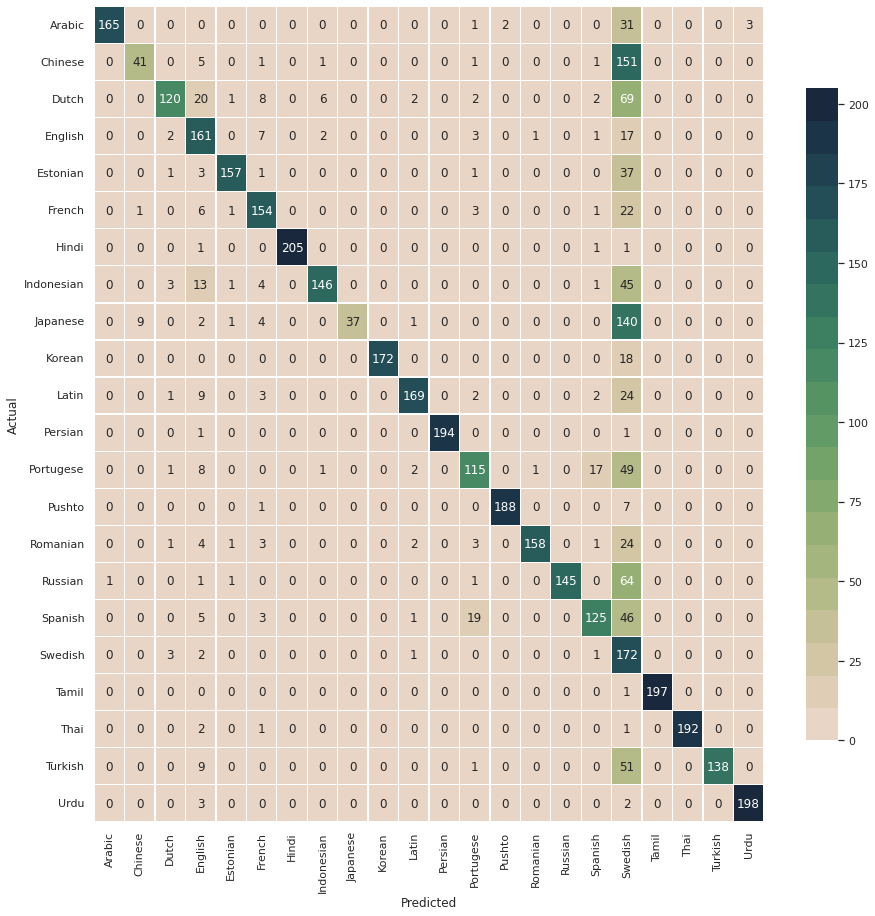

PCA and Explained Variance:
Variance explained by PCA: [0.02670683 0.02435323]


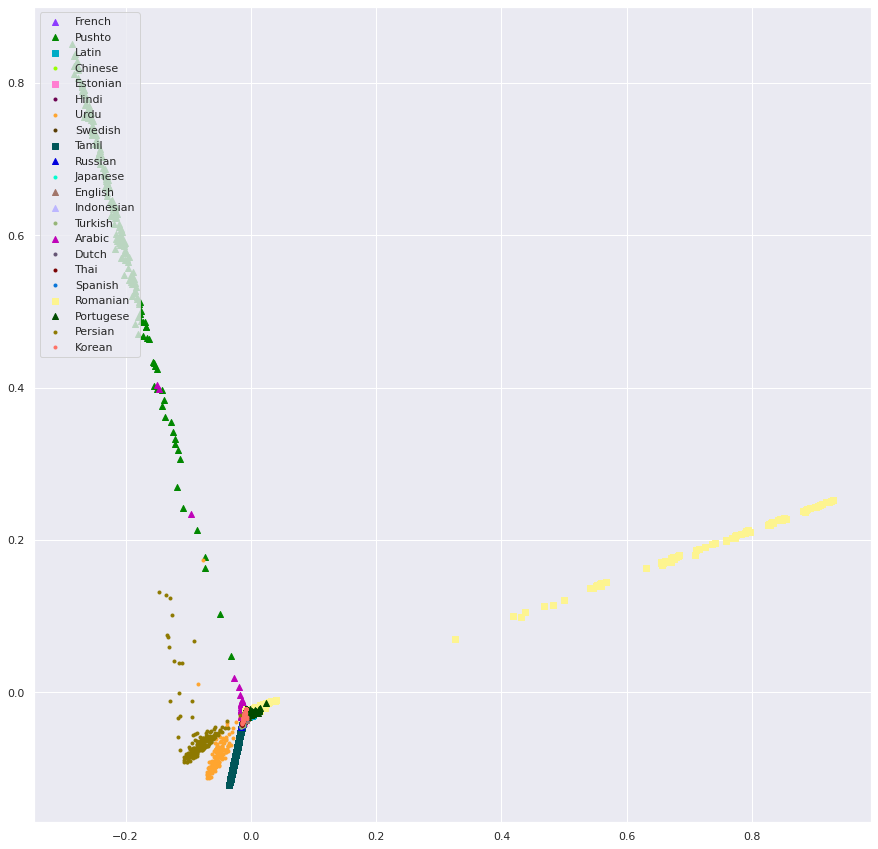

In [39]:
vocabulary = 1000
analyzer = 'word'
results(input, vocabulary, analyzer)

## Experiment : vocabulary size 2,000

STARTING HERE, TEXT NEEDS TO BE UDPATED FOR ALL FOLLOWING EXPERIMENTS

With a vocabulary size of 2,000 words:

- Coverage decreased from 0.303 to 0.292.
- F1 Score decreased from 0.903 to 0.902.

Languages {'French', 'Pushto', 'Latin', 'Chinese', 'Estonian', 'Hindi', 'Urdu', 'Swedish', 'Tamil', 'Russian', 'Japanese', 'English', 'Indonesian', 'Turkish', 'Arabic', 'Dutch', 'Thai', 'Spanish', 'Romanian', 'Portugese', 'Persian', 'Korean'}
Split sizes:
Train: 17600
Test: 4400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of tokens in the vocabulary: 2000
Coverage:  0.19369566300131155
Prediction Results:
F1: 0.8384090909090909 (micro), 0.8475517773930172 (macro), 0.8499979127702385 (weighted)


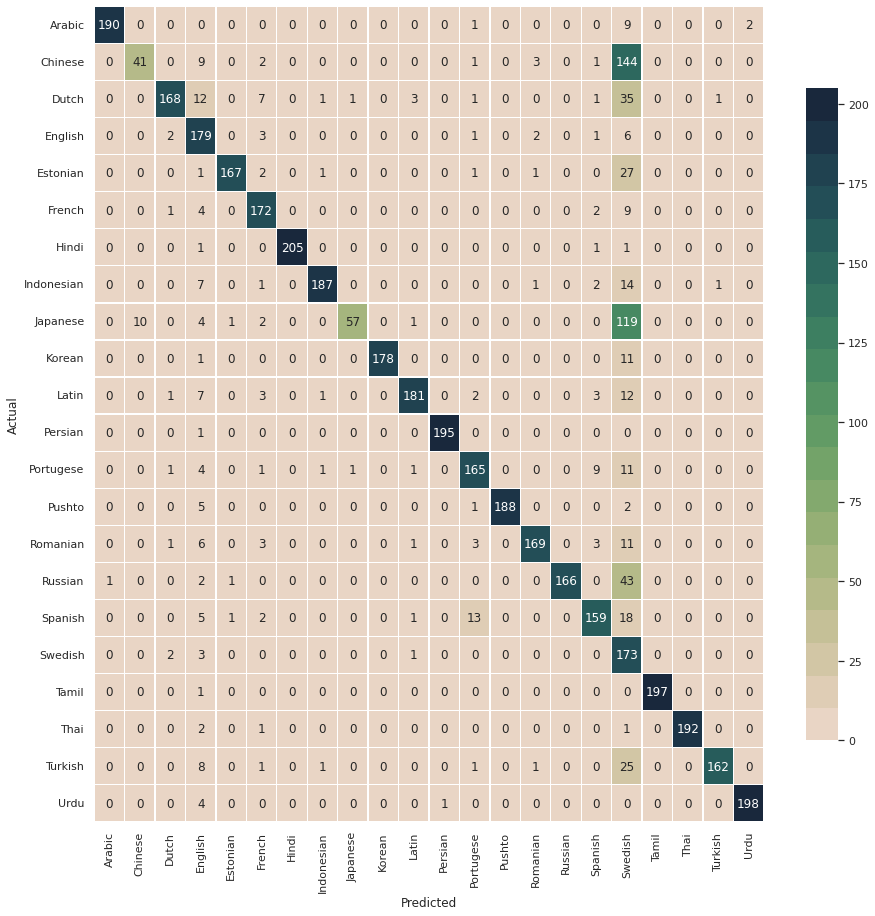

PCA and Explained Variance:
Variance explained by PCA: [0.02102996 0.02000618]


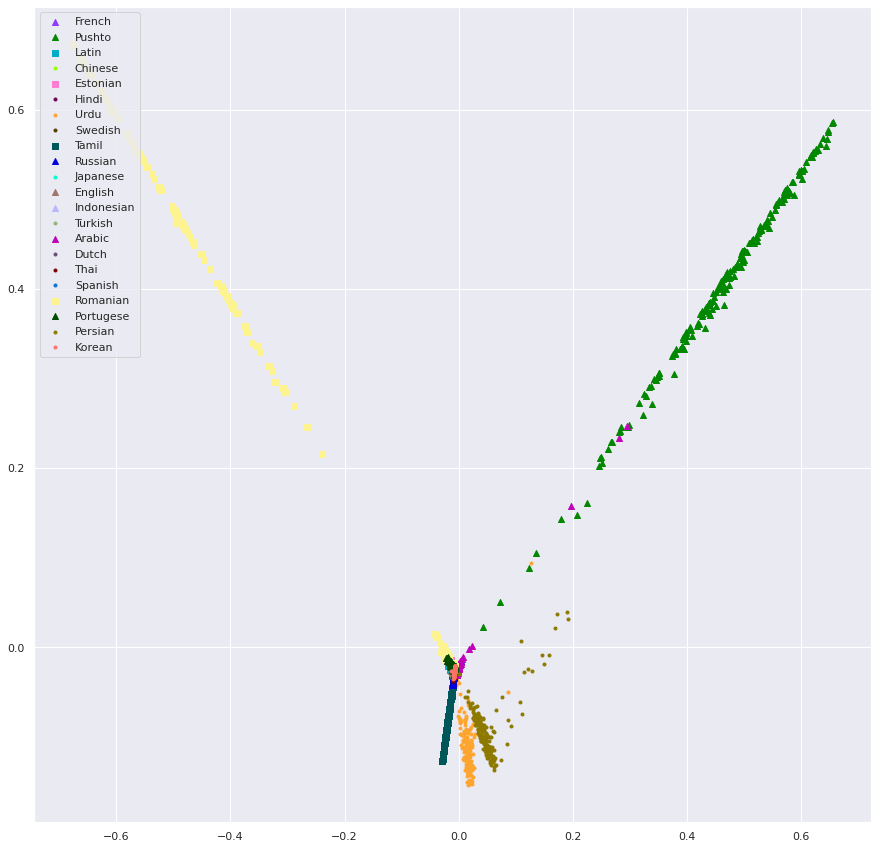

In [40]:
vocabulary = 2000
analyzer = 'word'
results(input, vocabulary, analyzer)

## Experiment : vocabulary size 500

With a vocabulary size of 500 words:

- Coverage decreased from 0.218 to 0.206. 
- F1 score decreased from 0.863 to 0.842.

Languages {'French', 'Pushto', 'Latin', 'Chinese', 'Estonian', 'Hindi', 'Urdu', 'Swedish', 'Tamil', 'Russian', 'Japanese', 'English', 'Indonesian', 'Turkish', 'Arabic', 'Dutch', 'Thai', 'Spanish', 'Romanian', 'Portugese', 'Persian', 'Korean'}
Split sizes:
Train: 17600
Test: 4400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of tokens in the vocabulary: 500
Coverage:  0.11288814118350203
Prediction Results:
F1: 0.6522727272727272 (micro), 0.6983262187545871 (macro), 0.6998233346100936 (weighted)


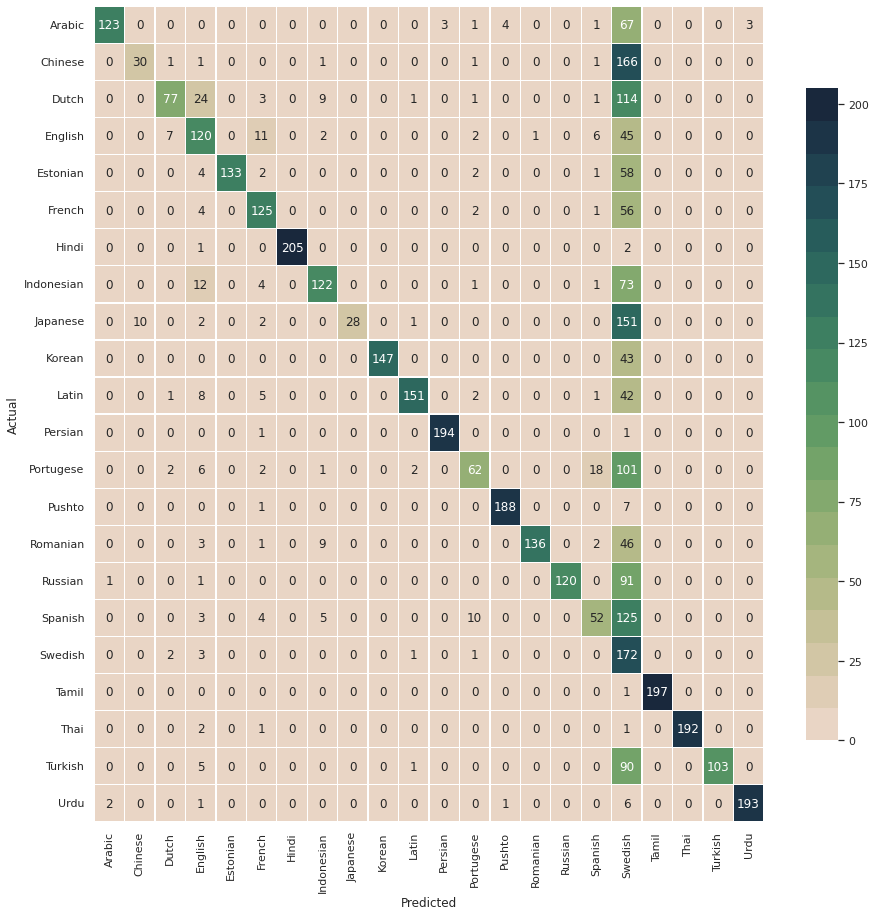

PCA and Explained Variance:
Variance explained by PCA: [0.03806565 0.03063517]


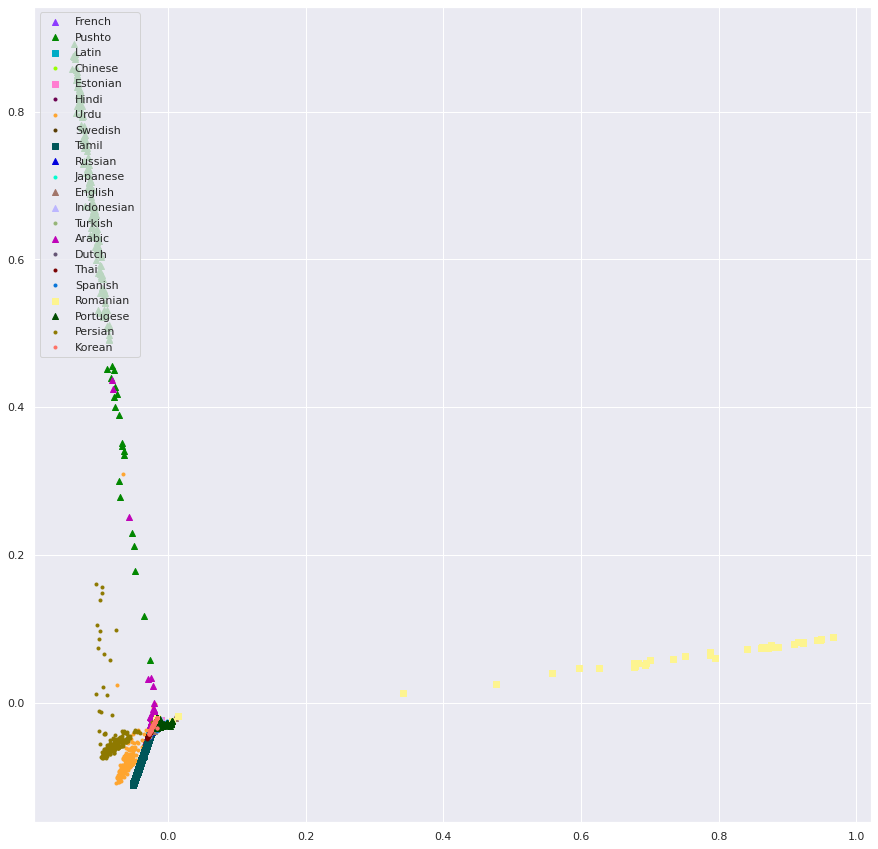

In [41]:
vocabulary = 500
analyzer = 'word'
results(input, vocabulary, analyzer)

## Experiment : vocabulary size 250

With a vocabulary size of 250 words:

- Coverage decreased from 0.185 to 0.173. 
- F1 score decreased from 0.823 to 0.782.


Languages {'French', 'Pushto', 'Latin', 'Chinese', 'Estonian', 'Hindi', 'Urdu', 'Swedish', 'Tamil', 'Russian', 'Japanese', 'English', 'Indonesian', 'Turkish', 'Arabic', 'Dutch', 'Thai', 'Spanish', 'Romanian', 'Portugese', 'Persian', 'Korean'}
Split sizes:
Train: 17600
Test: 4400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of tokens in the vocabulary: 250
Coverage:  0.08659608967299572
Prediction Results:
F1: 0.5147727272727273 (micro), 0.5663936103461397 (macro), 0.5638845897293341 (weighted)


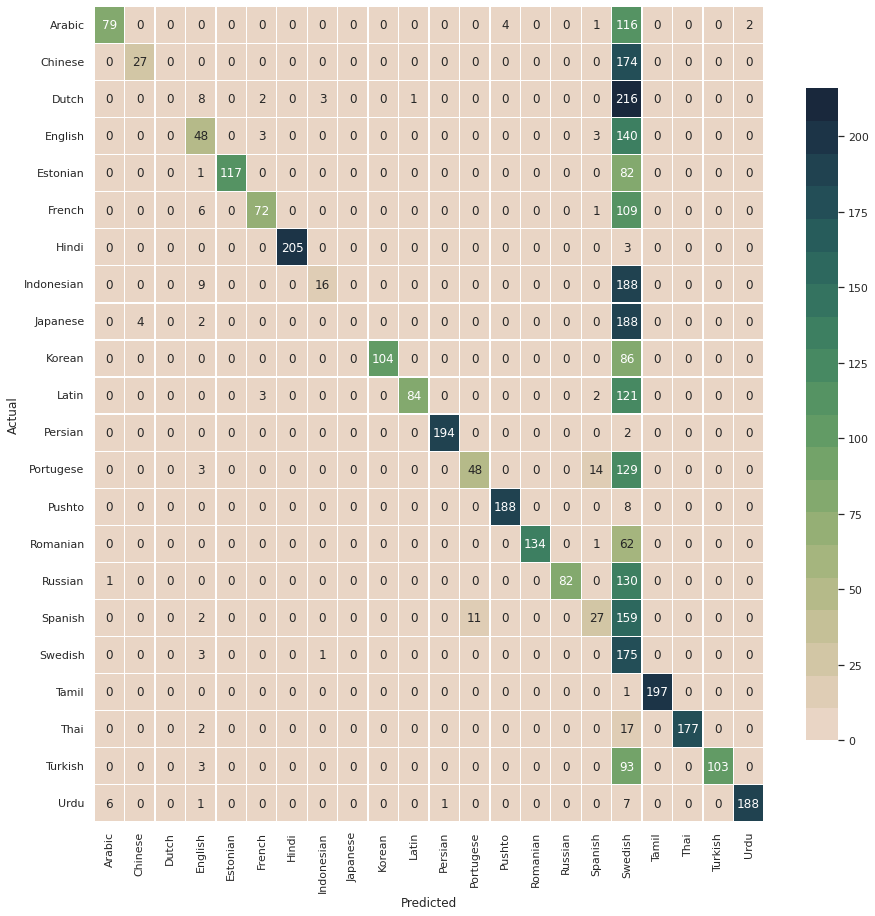

PCA and Explained Variance:
Variance explained by PCA: [0.05376216 0.04310068]


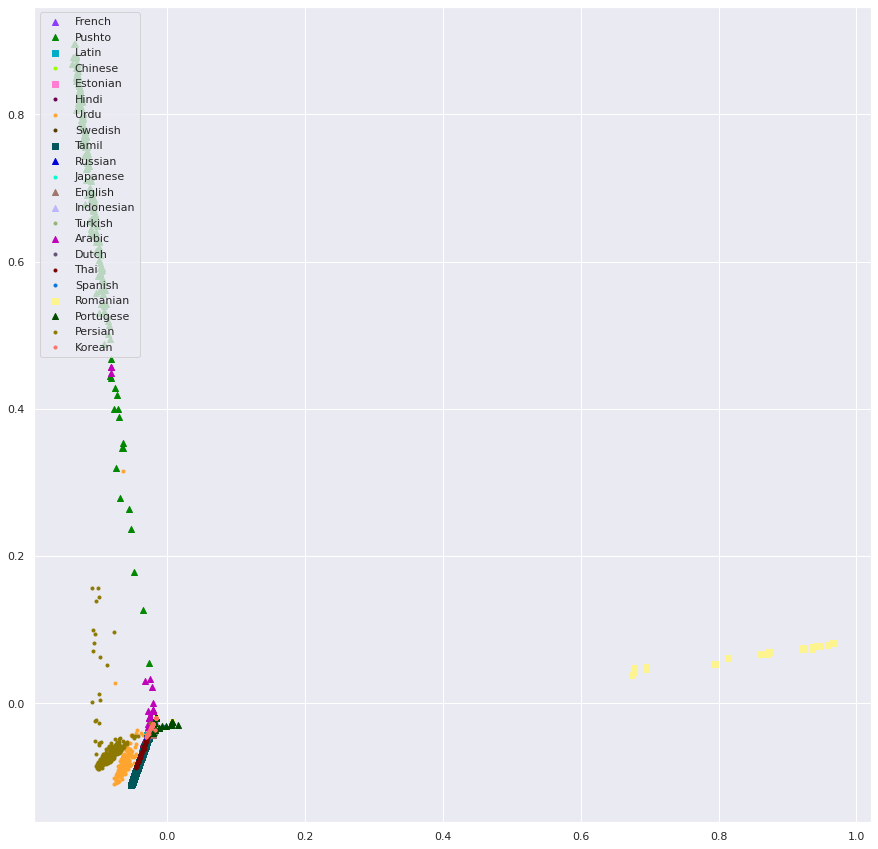

In [42]:
vocabulary = 250
analyzer = 'word'
results(input, vocabulary, analyzer)

## Experiment : vocabulary size 50

With a vocabulary size of 50 words:

- Coverage decreased from 0.106 to 0.101. 
- F1 score decreased from 0.687 to 0.625.


Languages {'French', 'Pushto', 'Latin', 'Chinese', 'Estonian', 'Hindi', 'Urdu', 'Swedish', 'Tamil', 'Russian', 'Japanese', 'English', 'Indonesian', 'Turkish', 'Arabic', 'Dutch', 'Thai', 'Spanish', 'Romanian', 'Portugese', 'Persian', 'Korean'}
Split sizes:
Train: 17600
Test: 4400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of tokens in the vocabulary: 50
Coverage:  0.05221885877775995
Prediction Results:
F1: 0.31727272727272726 (micro), 0.3012447887206681 (macro), 0.299603050962015 (weighted)


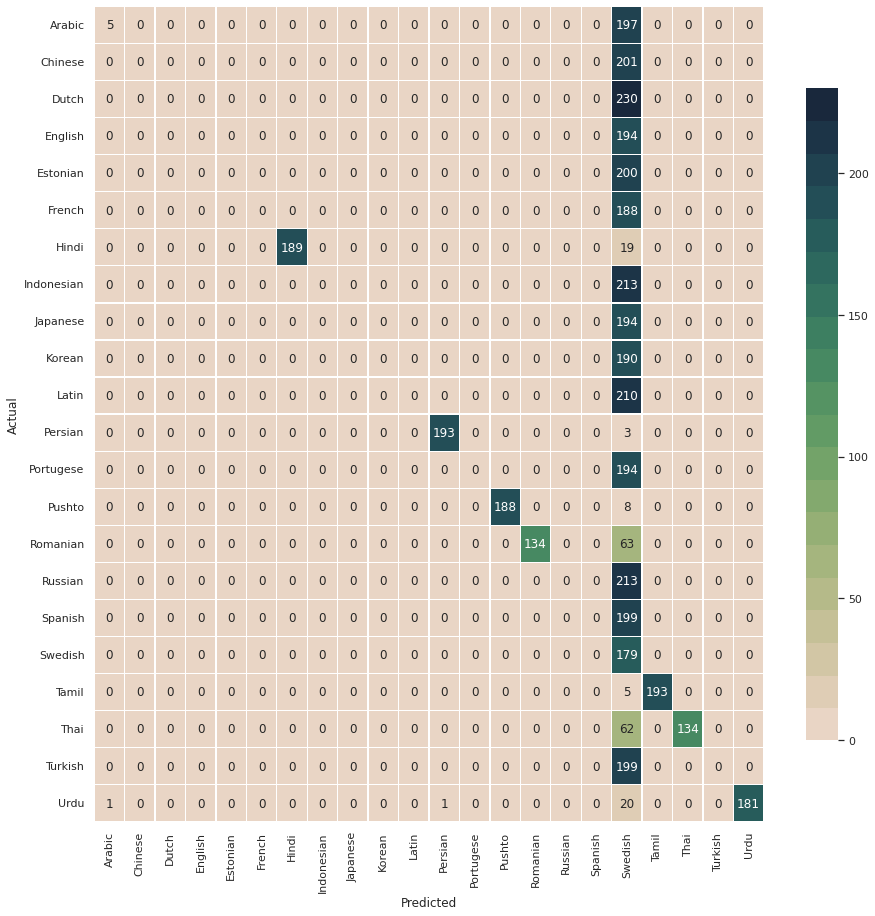

PCA and Explained Variance:
Variance explained by PCA: [0.11008329 0.10358355]


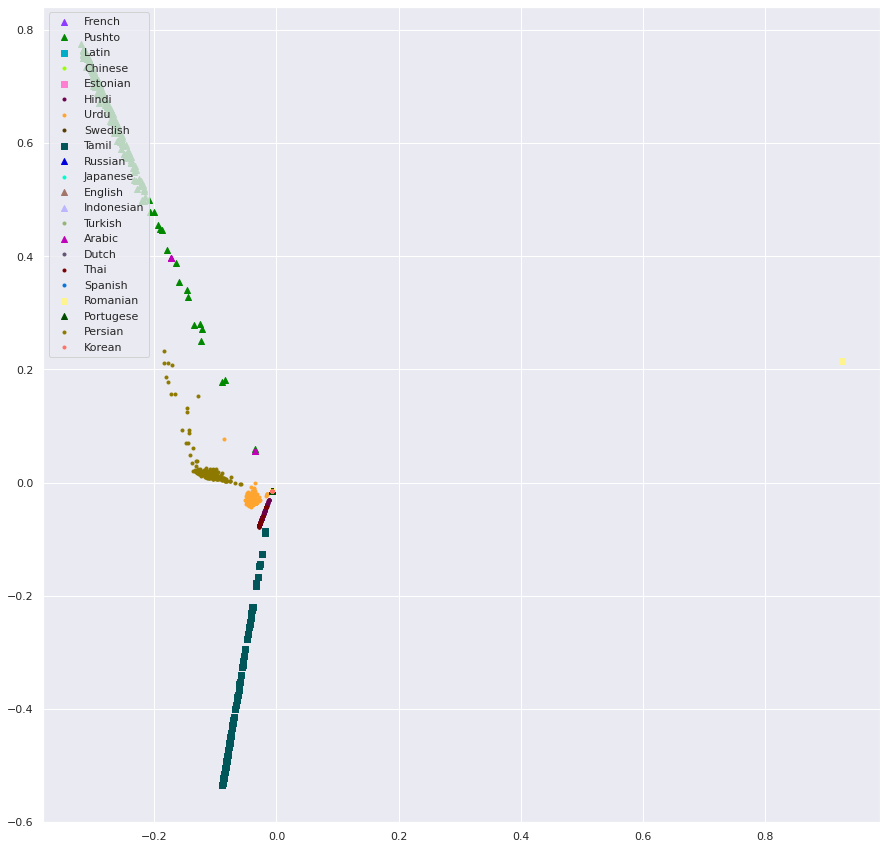

In [43]:
vocabulary = 50
analyzer = 'word'
results(input, vocabulary, analyzer)

## Experiment : vocabulary size 10,000

With a vocabulary size of 10,000 words:

- Coverage decreased from 0.436 to 0.434. 
- F1 score increased slightly from 0.915 to 0.92.


Languages {'French', 'Pushto', 'Latin', 'Chinese', 'Estonian', 'Hindi', 'Urdu', 'Swedish', 'Tamil', 'Russian', 'Japanese', 'English', 'Indonesian', 'Turkish', 'Arabic', 'Dutch', 'Thai', 'Spanish', 'Romanian', 'Portugese', 'Persian', 'Korean'}
Split sizes:
Train: 17600
Test: 4400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of tokens in the vocabulary: 10000
Coverage:  0.34447512742043485
Prediction Results:
F1: 0.9122727272727272 (micro), 0.9072234231581807 (macro), 0.909782945006391 (weighted)


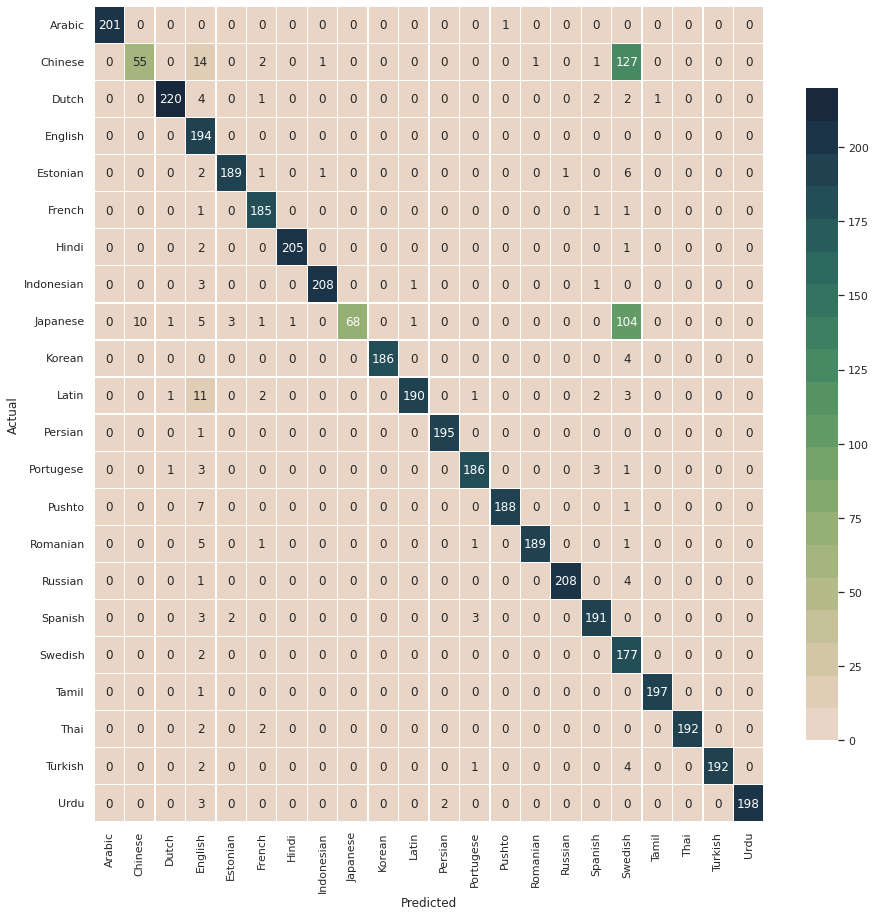

PCA and Explained Variance:
Variance explained by PCA: [0.01591642 0.01365218]


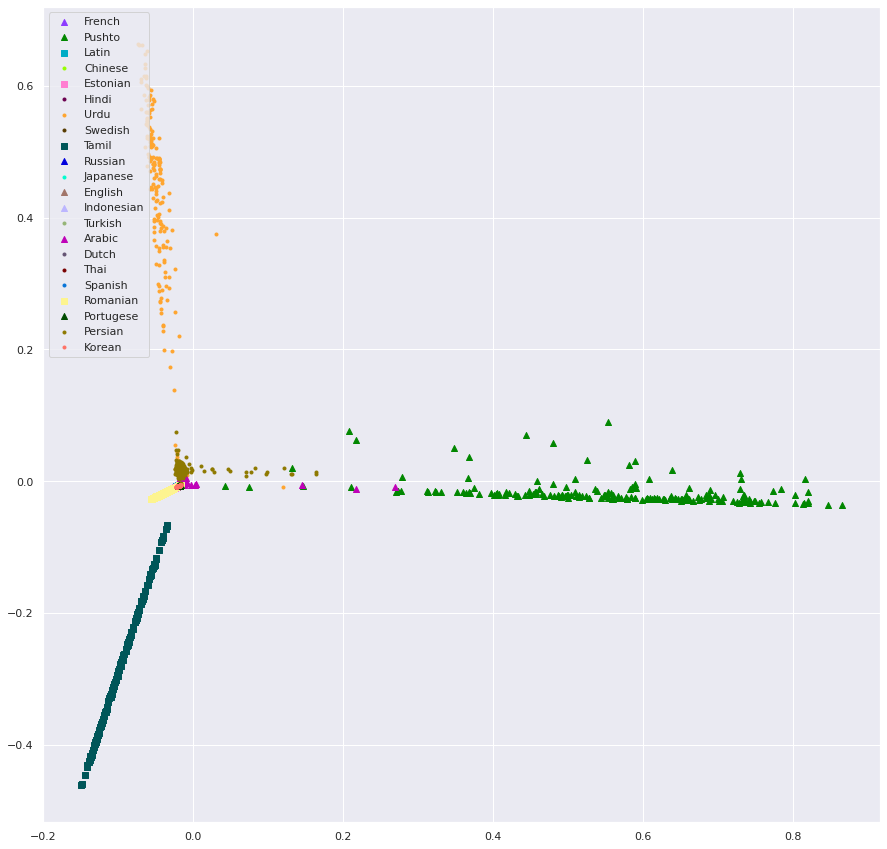

In [44]:
vocabulary = 10000
analyzer = 'word'
results(input, vocabulary, analyzer)

## Experiment : vocabulary size 20,000

With a vocabulary size of 20,000 words:

- Coverage increased from 0.496 to 0.498. 
- F1 score increased slightly from 0.922 to 0.924.

Languages {'French', 'Pushto', 'Latin', 'Chinese', 'Estonian', 'Hindi', 'Urdu', 'Swedish', 'Tamil', 'Russian', 'Japanese', 'English', 'Indonesian', 'Turkish', 'Arabic', 'Dutch', 'Thai', 'Spanish', 'Romanian', 'Portugese', 'Persian', 'Korean'}
Split sizes:
Train: 17600
Test: 4400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of tokens in the vocabulary: 20000
Coverage:  0.4201802978400784
Prediction Results:
F1: 0.9220454545454545 (micro), 0.9165909620688534 (macro), 0.9189688801424494 (weighted)


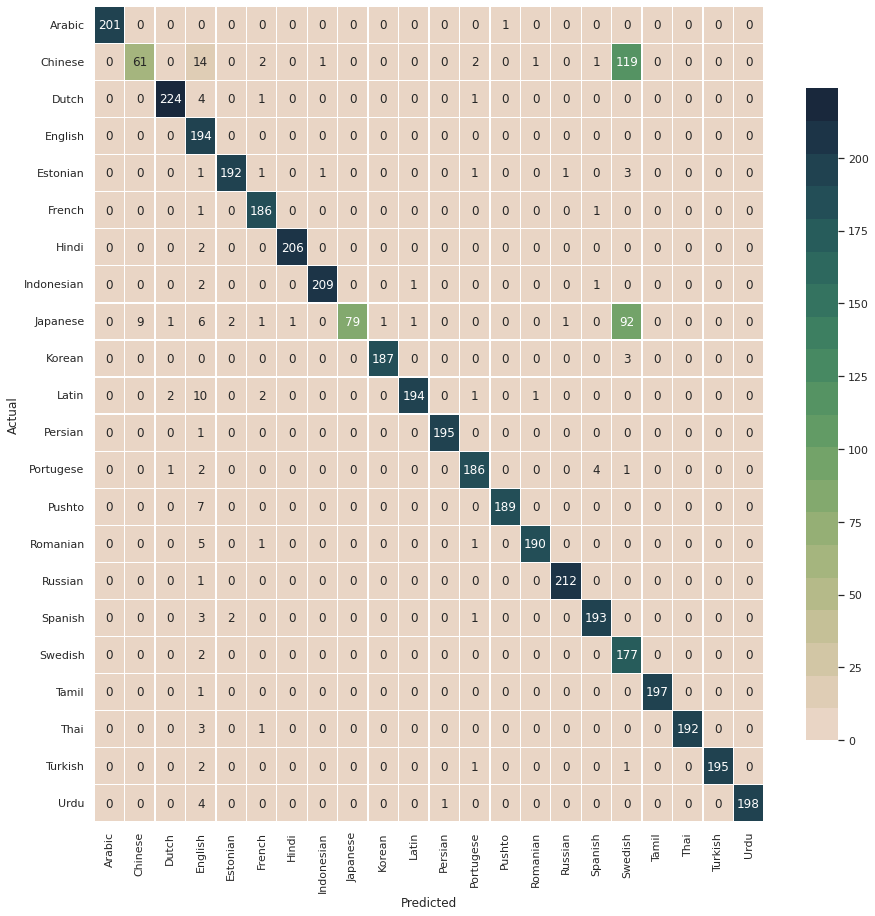

PCA and Explained Variance:
Variance explained by PCA: [0.01463873 0.01291598]


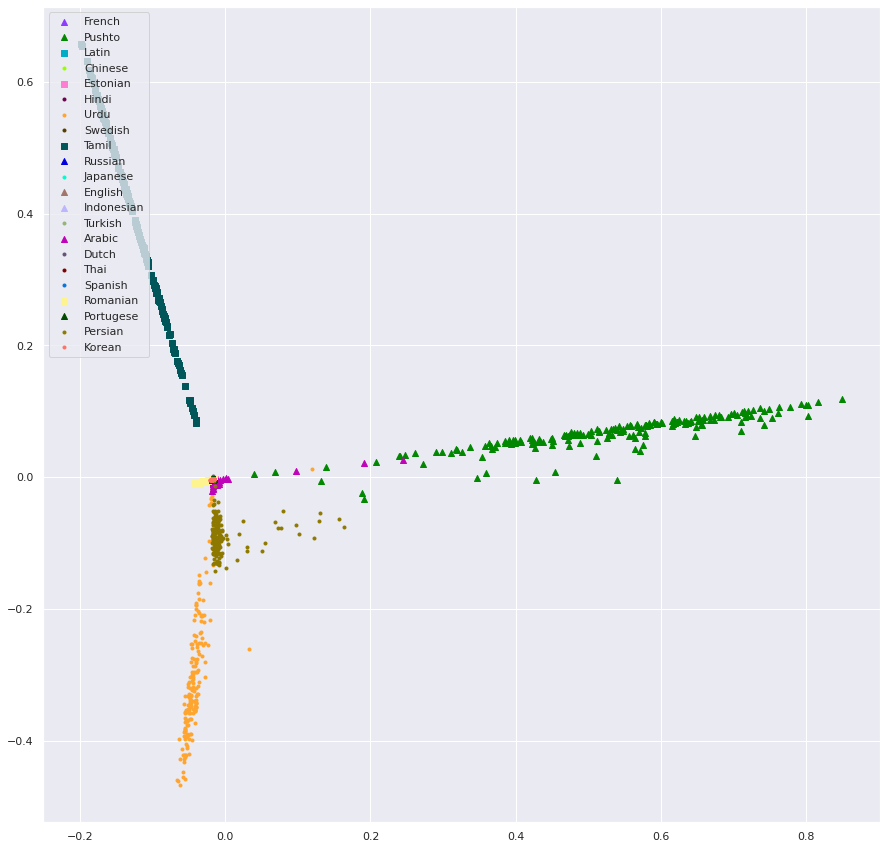

In [45]:
vocabulary = 20000
analyzer = 'word'
results(input, vocabulary, analyzer)

## Interpretation

**NEED TO UPDATE**

Depending on the token (char, word) the size of the vocabulary presents distinct results. The next graph illustrates the changes in coverage per char and word tokenization using different size of vocabulary.


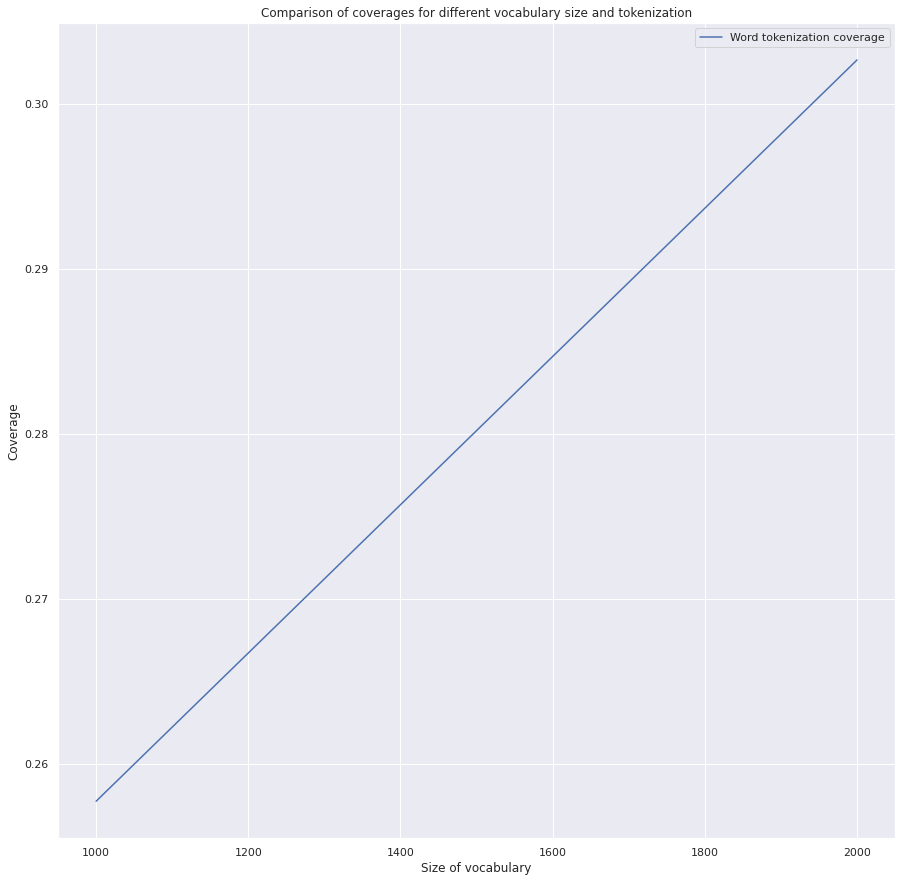

In [46]:
# Word experiments 
voc_word = [1000, 2000] # need to update
cov_word = [0.25771498027437495,0.30266285567313955]  # need to update

plt.plot(voc_word, cov_word, label = "Word tokenization coverage")
plt.xlabel('Size of vocabulary')
plt.ylabel('Coverage')
plt.title('Comparison of coverages for different vocabulary size and tokenization')
plt.legend()
plt.show()